In [1]:
import numpy as np 
import matplotlib.pylab as plt
from getdist import plots, MCSamples
import jax
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, HMC, NUTS, BarkerMH, init_to_median
from numpyro.handlers import seed
from numpyro.infer import Predictive, SVI, Trace_ELBO
import numpyro.infer.autoguide as autoguide

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 15

settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.3, 'smooth_scale_1D':0.3}
color1 = '#50C878' #'#B5CA8D'
color3 = '#222E50'
alpha = 0.5
palefactor = 0.9
linewidth = 2 
contours = [0.68,0.95]

In [2]:
ndata = 100
std = 0.5
xmin = 0.0 
xmax = 4.0 

In [3]:
def model(parameters, domain):
    return parameters[0]*domain**2 + parameters[1]*domain + parameters[2]

In [4]:
parameters = [1.0, -3, 0.0]
nparams = len(parameters)
priorcov = np.eye(nparams)
priorpre = np.linalg.inv(priorcov)
domain = np.linspace(xmin, xmax, ndata)
noisecov = np.eye(ndata) * std**2
noisepre = np.eye(ndata) * 1.0/std**2
design = np.ones((ndata, 3))
design[:,0] = domain**2
design[:,1] = domain
data = model(parameters, domain) + np.random.multivariate_normal(np.zeros_like(domain), noisecov)

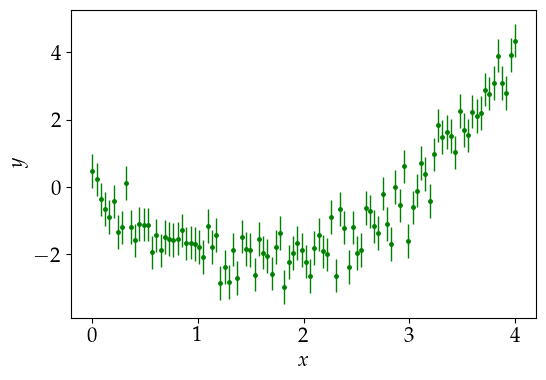

In [5]:
plt.figure(figsize = (6,4))
plt.errorbar(domain, data, yerr = std, color='green', fmt='.', markersize=5, ecolor='green',capsize=0.01, elinewidth=1)
plt.ylabel(r'$y$', fontsize = fontSize)
plt.xlabel(r'$x$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.show()

## Analytic

In [6]:
paramcov = np.linalg.inv(priorpre + design.T @ noisepre @ design)
parammean = paramcov @ design.T @ noisepre @ data

In [7]:
samples = np.random.multivariate_normal(parammean, paramcov, 10000)
names = ["x%s"%i for i in range(nparams)]
labels = [r'$\theta_{0}$', r'$\theta_{1}$', r'$\theta_{2}$']
samples_analytic = MCSamples(samples=samples, names = names, labels = labels, settings = settings, label = 'Analytic')

Removed no burn in


## Numpyro Model

In [34]:
def numpyro_model(data, domain, precision):
    theta0 = numpyro.sample("theta0", dist.Normal(0.0, 1.0))
    theta1 = numpyro.sample("theta1", dist.Normal(0.0, 1.0))
    theta2 = numpyro.sample("theta2", dist.Normal(0.0, 1.0))
    
    parameters = [theta0, theta1, theta2]
    theory = model(parameters, domain)
    sampling_distribution = dist.MultivariateNormal(theory, precision_matrix=precision)
    theory_sample = numpyro.sample("y", sampling_distribution, obs=data)
    log_prob = sampling_distribution.log_prob(theory_sample)
    return theory_sample, log_prob

In [35]:
with seed(rng_seed=42):
    theory, logprob = numpyro_model(data, domain, noisepre)

# NUTS

In [36]:
NWARMUP = 500
NSAMPLES = 10000

In [37]:
nuts_kernel = NUTS(numpyro_model, step_size=0.1, init_strategy=init_to_median, dense_mass=True, max_tree_depth=5)
mcmc_nuts = MCMC(nuts_kernel, num_warmup=NWARMUP, num_samples=NSAMPLES, num_chains=1, progress_bar=True)
mcmc_nuts.run(jax.random.PRNGKey(253), data, domain, noisepre)

sample: 100%|█████████████████████████████████████████████████████████████████████████| 10500/10500 [00:09<00:00, 1099.18it/s, 7 steps of size 6.36e-01. acc. prob=0.94]


In [38]:
nuts_samples = np.vstack([np.array(mcmc_nuts.get_samples()[f'theta{i}']) for i in range(nparams)]).T

In [39]:
samples_nuts = MCSamples(samples=nuts_samples, names = names, labels = labels, settings = settings, label = 'NUTS')

Removed no burn in


## Variational Inference

In [40]:
NITER = 10000

In [41]:
guide = autoguide.AutoMultivariateNormal(numpyro_model, init_loc_fn=numpyro.infer.init_to_median, init_scale = 0.1)
optimizer = numpyro.optim.Adam(step_size=0.01)
svi = SVI(numpyro_model, guide, optimizer, loss=Trace_ELBO())
svi_result = svi.run(jax.random.PRNGKey(0), NITER, data, domain, noisepre)

100%|████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2430.80it/s, init loss: 1789.9471, avg. loss [9501-10000]: 90.4292]


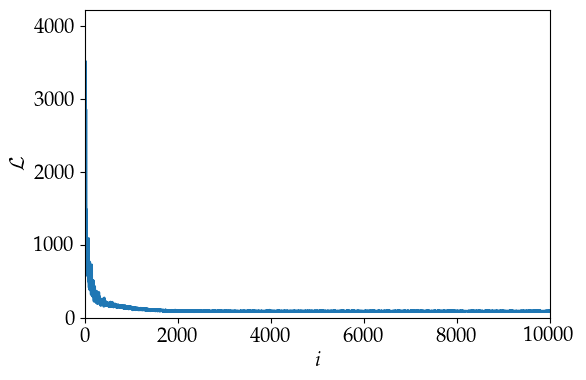

In [42]:
plt.figure(figsize=(6,4))
plt.plot(svi_result.losses, lw=2)
plt.xlim(0, NITER)
plt.ylim(0.0, 1.2*max(svi_result.losses))
plt.ylabel(r'$\mathcal{L}$', fontsize = fontSize)
plt.xlabel(r'$i$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.show()

In [43]:
predictive = Predictive(guide, params=svi_result.params, num_samples=20000)
draw_vi_samples = predictive(jax.random.PRNGKey(1))

In [44]:
vi_samples = np.vstack([np.array(draw_vi_samples[f'theta{i}']) for i in range(nparams)]).T

In [45]:
samples_vi = MCSamples(samples=vi_samples, names = names, labels = labels, settings = settings, label = 'VI')

Removed no burn in


## Plot

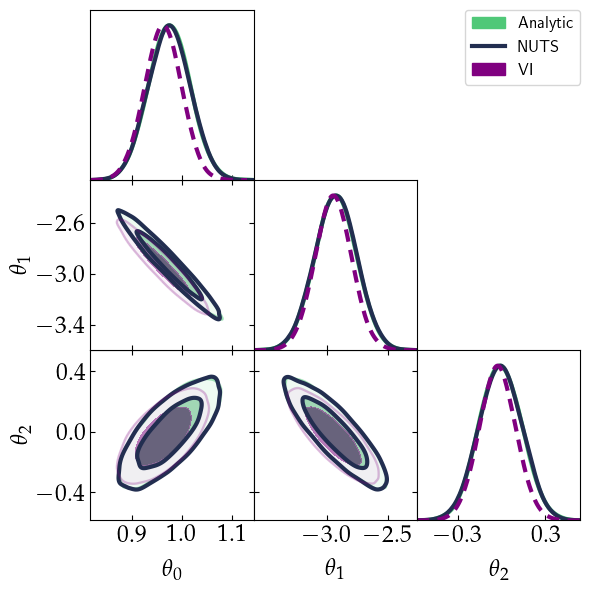

In [46]:
G = plots.getSubplotPlotter(subplot_size=2)
G.settings.solid_contour_palefactor = palefactor
G.settings.alpha_filled_add = alpha
G.settings.num_plot_contours = 2
G.settings.lw_contour = 3
G.settings.axes_fontsize = 20
G.settings.lab_fontsize = 20
G.settings.fontsize = 35 # important for padding in x-axis 
G.settings.legend_fontsize = 15
samples_analytic.updateSettings({'contours': [0.68, 0.95]})
samples_nuts.updateSettings({'contours': [0.68, 0.95]})
samples_vi.updateSettings({'contours': [0.68, 0.95]})
G.triangle_plot([samples_analytic, samples_nuts, samples_vi], filled = [True, False, True], contour_colors=[color1, color3, 'purple'], contour_lws=[3, 3, 3], contour_ls=['-', '-', '--'])
plt.show()